In [238]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import fiona
from pathlib import Path
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os
from rasterio.features import geometry_mask
from rasterio.transform import from_origin
from rasterio.windows import Window
from rasterio.plot import show
import scipy.ndimage as nd
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

In [239]:
base_path = Path("/Users/robynhaggis/Documents/Geospatial_analysis/Inputs")

In [240]:
jamaica_metric_grid_crs = "EPSG:3448"

In [241]:
jamaica_boundary_path = base_path / "Boundaries/jamaica.gpkg"
jamaica_boundary = gpd.read_file(jamaica_boundary_path)
print(jamaica_boundary.crs)

EPSG:3448


In [242]:
land_use = base_path / "2013_landuse_LandCover.shp"

In [243]:
terrestrial_landcover = gpd.read_file(land_use)
terrestrial_landcover = terrestrial_landcover.to_crs(jamaica_metric_grid_crs)
print(terrestrial_landcover.crs)

EPSG:3448


In [244]:
print(terrestrial_landcover.head())


   OBJECTID   Classify  Hectares  Shape_Leng LU_CODE  Shape_Le_1  \
0         1  Bare Rock  0.219042  217.030317      BR  217.030317   
1         2  Bare Rock  0.489814  306.713227      BR  306.713227   
2         3  Bare Rock  0.653918  363.027264      BR  363.027264   
3         4  Bare Rock  1.518056  661.429856      BR  661.429856   
4         5  Bare Rock  0.144238  259.855721      BR  259.855721   

     Shape_Area   Area new                                           geometry  
0   2190.423461   2190.423  POLYGON ((695760.683 632592.443, 695841.393 63...  
1   4898.144181   4898.144  POLYGON ((695594.285 632593.327, 695704.227 63...  
2   6539.178784   6539.179  POLYGON ((696433.566 632824.876, 696362.105 63...  
3  15180.560352  15180.560  POLYGON ((694375.817 633191.930, 694383.735 63...  
4   1442.383465   1442.383  POLYGON ((698016.285 633459.921, 698130.536 63...  


<Axes: >

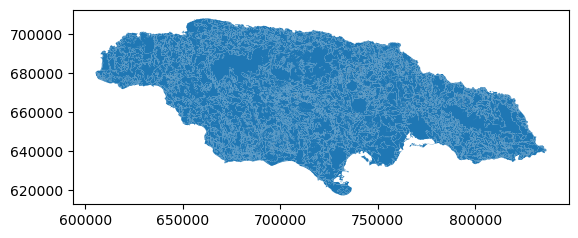

In [245]:
terrestrial_landcover.plot()

In [246]:
print(terrestrial_landcover['Classify'].unique())

['Bare Rock' 'Fields: Herbaceous crops, fallow, cultivated vegetables'
 'Fields: Pasture,Human disturbed, grassland' 'Herbaceous Wetland'
 'Mangrove Forest' 'Fields: Bare Land' 'Open dry forest - Short'
 'Open dry forest - Tall (Woodland/Savanna)'
 'Plantation: Tree crops, shrub crops, sugar cane, banana' 'Quarry'
 'Water Body' 'Buildings and other infrastructures'
 'Fields and Secondary Forest' 'Bamboo and Fields' 'Bauxite Extraction'
 'Disturbed broadleaved forest (Secondary Forest)' 'Fields  and Bamboo'
 'Bamboo and Secondary Forest' 'Hardwood Plantation: Euculytus'
 'Hardwood Plantation: Mixed' 'Swamp Forest'
 'Fields or Secondary Forest/Pine Plantation' 'Hardwood Plantation: Mahoe'
 'Hardwood Plantation: Mahogany' 'Bamboo'
 'Closed broadleaved forest (Primary Forest)' 'Secondary Forest']


In [247]:
categories = terrestrial_landcover['Classify'].unique()
# Display the categories
print("Land Use Categories:")
for category in categories:
    print("-", category)

Land Use Categories:
- Bare Rock
- Fields: Herbaceous crops, fallow, cultivated vegetables
- Fields: Pasture,Human disturbed, grassland
- Herbaceous Wetland
- Mangrove Forest
- Fields: Bare Land
- Open dry forest - Short
- Open dry forest - Tall (Woodland/Savanna)
- Plantation: Tree crops, shrub crops, sugar cane, banana
- Quarry
- Water Body
- Buildings and other infrastructures
- Fields and Secondary Forest
- Bamboo and Fields
- Bauxite Extraction
- Disturbed broadleaved forest (Secondary Forest)
- Fields  and Bamboo
- Bamboo and Secondary Forest
- Hardwood Plantation: Euculytus
- Hardwood Plantation: Mixed
- Swamp Forest
- Fields or Secondary Forest/Pine Plantation
- Hardwood Plantation: Mahoe
- Hardwood Plantation: Mahogany
- Bamboo
- Closed broadleaved forest (Primary Forest)
- Secondary Forest


In [248]:
# Calculate area in square meters
terrestrial_landcover['area_m2'] = terrestrial_landcover.geometry.area

# Group by 'Classify' and sum the areas
area_by_category = terrestrial_landcover.groupby('Classify')['area_m2'].sum().reset_index()

# Display the results
print(area_by_category)

# Calculate total area
total_area = area_by_category['area_m2'].sum()
print(f"Total Area: {total_area:.2f} square meters")

# Calculate percentage for each category
area_by_category['percentage'] = (area_by_category['area_m2'] / total_area) * 100

# Sort the DataFrame by percentage in descending order
area_by_category = area_by_category.sort_values(by='percentage', ascending=False)

# Display the updated DataFrame
display(area_by_category)

                                             Classify       area_m2
0                                              Bamboo  4.667409e+07
1                                   Bamboo and Fields  2.952655e+08
2                         Bamboo and Secondary Forest  3.495814e+08
3                                           Bare Rock  2.340503e+07
4                                  Bauxite Extraction  3.393043e+07
5                 Buildings and other infrastructures  1.178559e+09
6          Closed broadleaved forest (Primary Forest)  8.464405e+08
7     Disturbed broadleaved forest (Secondary Forest)  1.748388e+09
8                                  Fields  and Bamboo  3.730854e+08
9                         Fields and Secondary Forest  1.455115e+09
10         Fields or Secondary Forest/Pine Plantation  8.012892e+07
11                                  Fields: Bare Land  7.156254e+07
12  Fields: Herbaceous crops, fallow, cultivated v...  1.534834e+09
13         Fields: Pasture,Human disturbed, gras

,Classify,area_m2,percentage
7,Disturbed broadleaved forest (Secondary Forest),1.748388e+09,15.947103
12,"Fields: Herbaceous crops, fallow, cultivated v...",1.534834e+09,13.999271
24,Secondary Forest,1.457161e+09,13.290815
9,Fields and Secondary Forest,1.455115e+09,13.272154
5,Buildings and other infrastructures,1.178559e+09,10.749678
6,Closed broadleaved forest (Primary Forest),8.464405e+08,7.720412
22,"Plantation: Tree crops, shrub crops, sugar can...",6.996513e+08,6.381542
21,Open dry forest - Tall (Woodland/Savanna),3.751660e+08,3.421901
8,Fields and Bamboo,3.730854e+08,3.402924
2,Bamboo and Secondary Forest,3.495814e+08,3.188544


In [249]:
# Format the DataFrame for better readability
area_by_category['area_km2'] = area_by_category['area_m2'] / 1e6  # Convert area to square kilometers
area_by_category['percentage'] = area_by_category['percentage'].round(2)  # Round percentage to 2 decimal places

# Select and reorder columns
area_summary = area_by_category[['Classify', 'area_km2', 'percentage']]

# Rename columns for clarity
area_summary.columns = ['Land Use Category', 'Area (km²)', 'Percentage of Total Area (%)']

# Display the summary table
print(area_summary)

                                    Land Use Category   Area (km²)  \
7     Disturbed broadleaved forest (Secondary Forest)  1748.387838   
12  Fields: Herbaceous crops, fallow, cultivated v...  1534.833901   
24                                   Secondary Forest  1457.161146   
9                         Fields and Secondary Forest  1455.115187   
5                 Buildings and other infrastructures  1178.559309   
6          Closed broadleaved forest (Primary Forest)   846.440523   
22  Plantation: Tree crops, shrub crops, sugar can...   699.651283   
21          Open dry forest - Tall (Woodland/Savanna)   375.165952   
8                                  Fields  and Bamboo   373.085406   
2                         Bamboo and Secondary Forest   349.581433   
1                                   Bamboo and Fields   295.265489   
18                                 Herbaceous Wetland   143.745615   
19                                    Mangrove Forest    95.188792   
10         Fields or

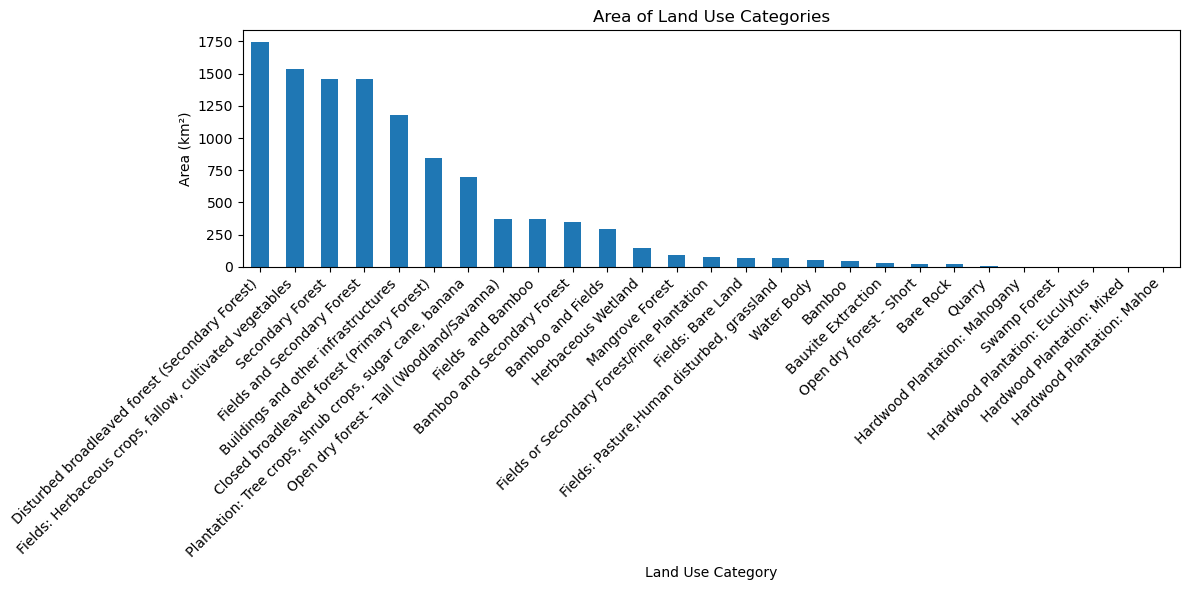

In [250]:
import matplotlib.pyplot as plt

# Plot the area of each land use category
area_summary.plot(
    x='Land Use Category',
    y='Area (km²)',
    kind='bar',
    legend=False,
    figsize=(12, 6)
)
plt.ylabel('Area (km²)')
plt.title('Area of Land Use Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

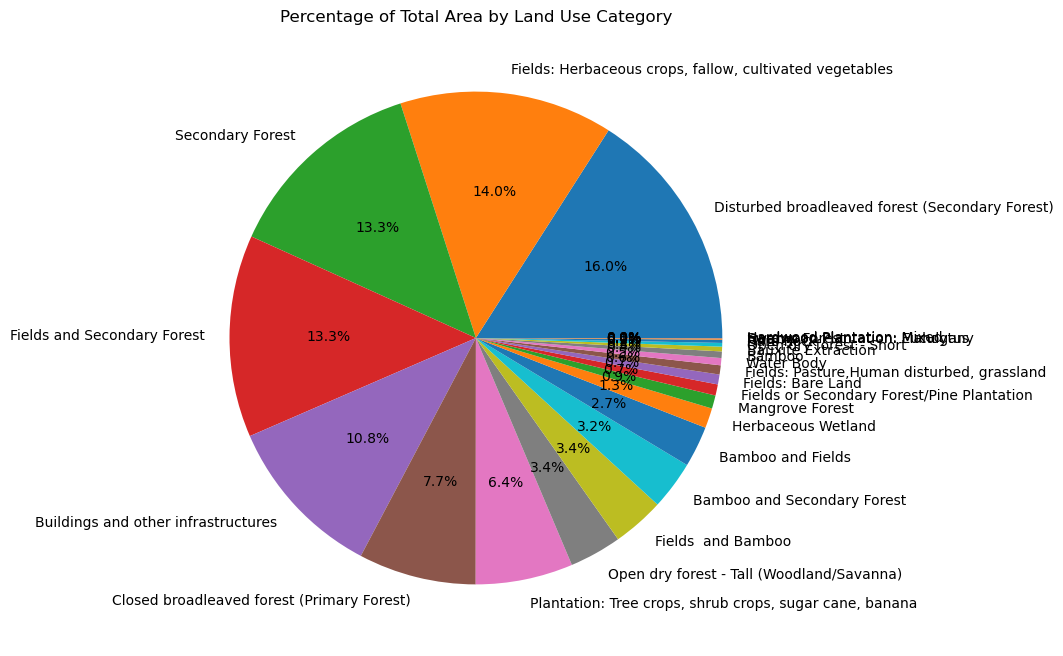

In [251]:
# Plot the percentage of each land use category
area_summary.set_index('Land Use Category')['Percentage of Total Area (%)'].plot(
    kind='pie',
    autopct='%1.1f%%',
    figsize=(8, 8)
)
plt.ylabel('')
plt.title('Percentage of Total Area by Land Use Category')
plt.show()

In [252]:
#Land Use Categories:
#- Agriculture
#- Forest
#- Urban
#- Wetland
#- Grassland

# Example mapping dictionary
landuse_category_mapping = {
    'Bare Rock': 'Bare Rock',
    'Fields: Herbaceous crops, fallow, cultivated vegetables': 'Agriculture',
    'Fields: Pasture,Human disturbed, grassland': 'Agriculture',
    'Herbaceous Wetland': 'Freshwater wetland',
    'Mangrove Forest': 'Mangrove',
    'Fields: Bare Land': 'Agriculture',
    'Open dry forest - Short': 'Open dry forest',
    'Open dry forest - Tall (Woodland/Savanna)': 'Open dry forest',
    'Plantation: Tree crops, shrub crops, sugar cane, banana': 'Plantation',
    'Quarry': 'Bauxite extraction / quarry',
    'Water Body': 'Water body',
    'Buildings and other infrastructures': 'Buildings and other infrastructure',
    'Fields and Secondary Forest': 'Mixed land use: forests with bamboo or agriculture/plantation',
    'Bamboo and Fields': 'Mixed land use: agriculture and bamboo',
    'Bauxite Extraction': 'Bauxite extraction / quarry',
    'Disturbed broadleaved forest (Secondary Forest)': 'Forest',
    'Fields  and Bamboo': 'Mixed land use: agriculture and bamboo',
    'Bamboo and Secondary Forest': 'Mixed land use: agriculture and bamboo',
    'Hardwood Plantation: Euculytus': 'Plantation',
    'Hardwood Plantation: Mixed': 'Plantation',
    'Swamp Forest': 'Swamp forest',
    'Fields or Secondary Forest/Pine Plantation': 'Mixed land use: forests with bamboo or agriculture/plantation',
    'Hardwood Plantation: Mahoe': 'Plantation',
    'Hardwood Plantation: Mahogany': 'Plantation',
    'Bamboo': 'Bamboo',
    'Closed broadleaved forest (Primary Forest)': 'Forest',
    'Secondary Forest': 'Forest'
    # Add other mappings as needed
}


# Map the categories
terrestrial_landcover['Classify'] = terrestrial_landcover['Classify'].replace(landuse_category_mapping)

,Land Use Category,Area (km²),Percentage of Total Area (%)
0,Agriculture,1672.612294,15.26
1,Bamboo,46.674093,0.43
2,Bare Rock,23.405028,0.21
3,Bauxite extraction / quarry,41.133689,0.38
4,Buildings and other infrastructure,1178.559309,10.75
5,Forest,4051.989507,36.96
6,Freshwater wetland,143.745615,1.31
7,Mangrove,95.188792,0.87
8,Mixed land use: agriculture and bamboo,1017.932328,9.28
9,Mixed land use: forests with bamboo or agricul...,1535.244109,14.00


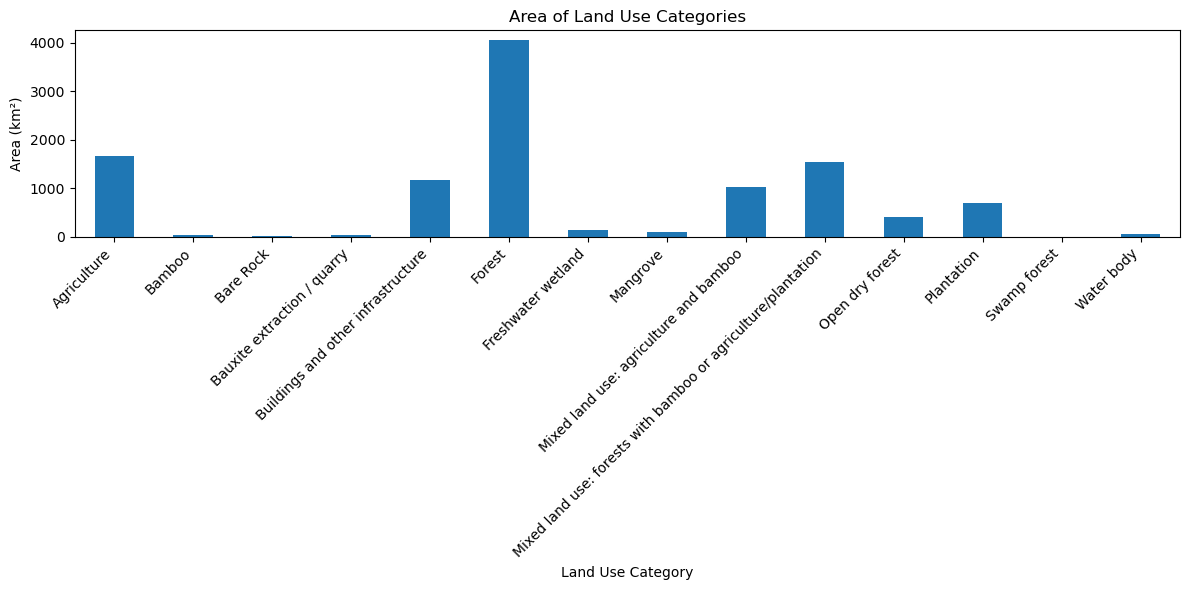

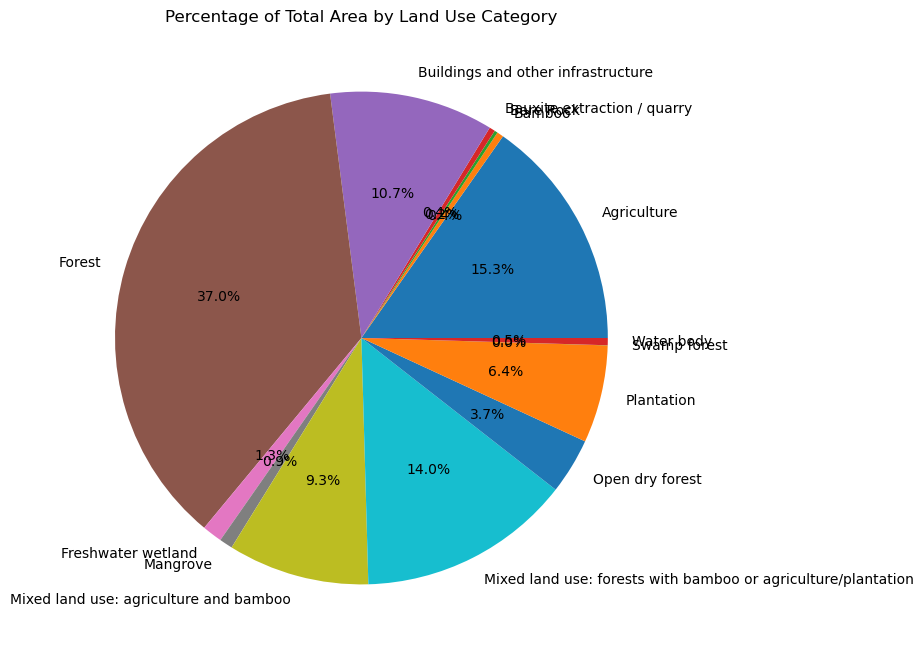

In [253]:
# Calculate area in square meters
terrestrial_landcover['area_m2'] = terrestrial_landcover.geometry.area

# Handle invalid geometries if necessary
# terrestrial_landcover['geometry'] = terrestrial_landcover['geometry'].buffer(0)

# Drop rows with missing 'Classify' values
terrestrial_landcover = terrestrial_landcover.dropna(subset=['Classify'])

# Group by 'Classify' and sum the areas
area_by_category = terrestrial_landcover.groupby('Classify')['area_m2'].sum().reset_index()

# Calculate total area
total_area = area_by_category['area_m2'].sum()

# Calculate percentage for each category
area_by_category['percentage'] = (area_by_category['area_m2'] / total_area) * 100

# Convert area to square kilometers
area_by_category['area_km2'] = area_by_category['area_m2'] / 1e6

# Round the percentage
area_by_category['percentage'] = area_by_category['percentage'].round(2)

# Select and reorder columns
area_summary = area_by_category[['Classify', 'area_km2', 'percentage']]

# Rename columns for clarity
area_summary.columns = ['Land Use Category', 'Area (km²)', 'Percentage of Total Area (%)']

# Display the summary table
display(area_summary)

# Plot the area of each land use category
area_summary.plot(
    x='Land Use Category',
    y='Area (km²)',
    kind='bar',
    legend=False,
    figsize=(12, 6)
)
plt.ylabel('Area (km²)')
plt.title('Area of Land Use Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot the percentage of each land use category
area_summary.set_index('Land Use Category')['Percentage of Total Area (%)'].plot(
    kind='pie',
    autopct='%1.1f%%',
    figsize=(8, 8)
)
plt.ylabel('')
plt.title('Percentage of Total Area by Land Use Category')
plt.show()

/var/folders/x6/l70lvh3n02zd5hydyxdh1l0h0000gn/T/ipykernel_9027/4275829419.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set3', len(categories))


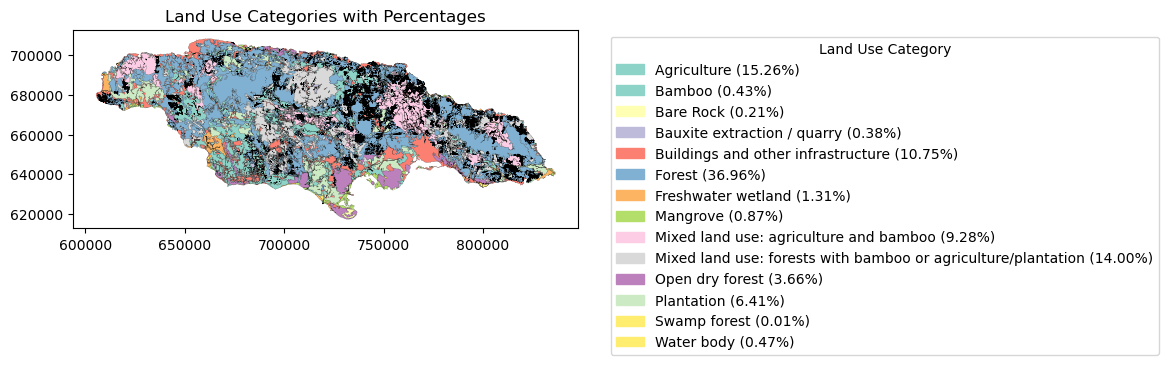

In [254]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Get the list of categories and percentages from area_summary
categories = area_summary['Land Use Category'].tolist()
percentages = area_summary['Percentage of Total Area (%)'].tolist()

# Create a color map with as many colors as categories
# You can choose any colormap you like (e.g., 'Set3', 'tab20', 'tab10')
cmap = plt.cm.get_cmap('Set3', len(categories))

# Assign colors to categories
category_colors = {}
for idx, category in enumerate(categories):
    # Get a color from the colormap
    color = mcolors.rgb2hex(cmap(idx))
    category_colors[category] = color

# Map colors to the GeoDataFrame
terrestrial_landcover['color'] = terrestrial_landcover['Classify'].map(category_colors)

# Plot the GeoDataFrame with the assigned colors
fig, ax = plt.subplots(figsize=(12, 8))
terrestrial_landcover.plot(
    ax=ax,
    color=terrestrial_landcover['color'],
    linewidth=0.1,
    edgecolor='black'
)

# Create custom legend
legend_handles = []
for category, percentage in zip(categories, percentages):
    color = category_colors[category]
    label = f"{category} ({percentage:.2f}%)"
    patch = mpatches.Patch(color=color, label=label)
    legend_handles.append(patch)

# Add legend to the plot
ax.legend(
    handles=legend_handles,
    title='Land Use Category',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.title('Land Use Categories with Percentages')
plt.tight_layout()
plt.show()

/var/folders/x6/l70lvh3n02zd5hydyxdh1l0h0000gn/T/ipykernel_9027/2653917736.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set3', len(remaining_categories))


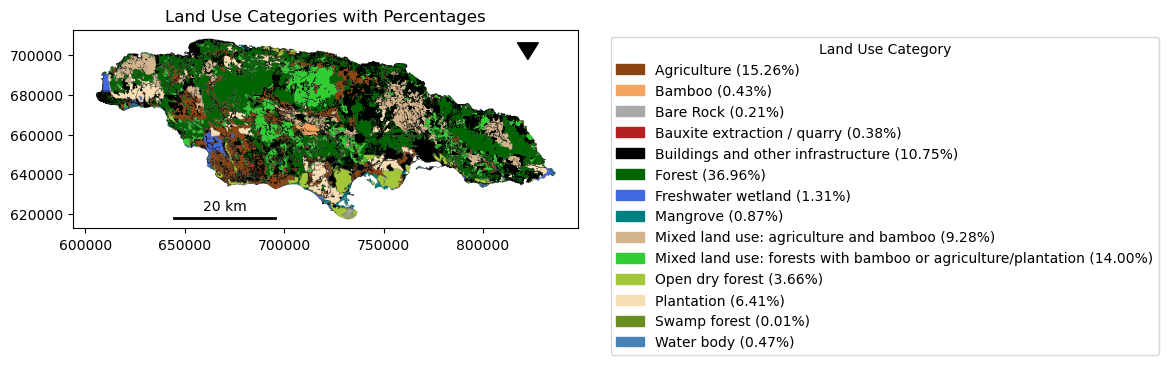

In [301]:
# Define custom colors for specified categories

custom_colors = {
    'Bare Rock': '#A9A9A9',  # Dark Gray (rocky terrain)
    'Agriculture': '#8B4513',  # Dark Brown
    'Freshwater wetland': '#4169E1', #Royal blue
    'Mangrove': '#008080', # Teal Blue
    'Open dry forest': '#A4C639', # Light green 90EE90   
    'Plantation': '#F5DEB3', #  yellow
    'Bauxite extraction / quarry': '#B22222', #Iron Oxide Red
    'Water body': '#4682B4',  # Steel Blue
    'Buildings and other infrastructure': '#000000',  # Black
    'Mixed land use: forests with bamboo or agriculture/plantation': '#32CD32',  # lime Green
    'Mixed land use: agriculture and bamboo': '#D2B48C',  #light brown
    'Swamp forest': '#6B8E23',  # Olive Drab
    'Bamboo': '#F4A460',  # Sandy Brown
    'Forest': '#006400',  # Dark Green
}

# custom_colors = {
#     'Agriculture': '#8B4513',   # Dark brown
#     'Primary broadleaved forest': '#006400',  # Dark green
#     'Secondary forest': '#228B22',  # Forest Green 
#     'Bare Rock': '#676767', # Granite gray
#     'Plantation': '#D2B48C',  # Light brown
#     'Buildings and other infrastructure': '#000000',  # Black
#     'Open dry forest: short': '#32CD32',  # Grass Green
#     'Open dry forest: tall': '#9ACD32', # Yellow green
#     #'#6B8E23',  # Olive Drab
#     'Bamboo': '#F5F5DC', # Beige
#     'Freshwater wetland': 
#     'Mangrove': '#2E8B57',  # Sea Green
#     'Mixed land use: fields and bamboo': '#3CB371',  # Medium Sea Green
#     'Swamp forest': 
#     #'#228B22',  # Forest Green
#     'Bauxite extraction / quarry': 
#     'Water body': '#ADD8E6', #Light blue
#'#7CFC00',  # Lawn Green

# }

# Get the list of all categories
all_categories = area_summary['Land Use Category'].tolist()

# Categories without custom colors
remaining_categories = [cat for cat in all_categories if cat not in custom_colors]

# Create a colormap for remaining categories
cmap = plt.cm.get_cmap('Set3', len(remaining_categories))

# Assign colors to remaining categories
colormap_colors = {}
for idx, category in enumerate(remaining_categories):
    color = mcolors.rgb2hex(cmap(idx))
    colormap_colors[category] = color

# Combine custom colors with colormap colors
category_colors = {**custom_colors, **colormap_colors}

# Map colors to the GeoDataFrame
terrestrial_landcover['color'] = terrestrial_landcover['Classify'].map(category_colors)

# Plot the GeoDataFrame with the assigned colors
fig, ax = plt.subplots(figsize=(12, 8))
terrestrial_landcover.plot(
    ax=ax,
    color=terrestrial_landcover['color'],
    linewidth=0.1,
    edgecolor='black'
)

# Prepare legend handles
legend_handles = []
for category, percentage in zip(all_categories, area_summary['Percentage of Total Area (%)']):
    color = category_colors[category]
    label = f"{category} ({percentage:.2f}%)"
    patch = mpatches.Patch(color=color, label=label)
    legend_handles.append(patch)

# Add legend to the plot
ax.legend(
    handles=legend_handles,
    title='Land Use Category',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

# Function to add a north arrow
def add_north_arrow(ax, size=20, location=(0.95, 0.1)):
    """
    Add a north arrow to a plot.
    - ax: the axis to add the north arrow to.
    - size: the font size for the "N" label.
    - location: tuple for the arrow's location (relative to the axis).
    """
    ax.annotate(
        'N', xy=location, xycoords='axes fraction',
        fontsize=size, fontweight='bold', color='black', ha='center', va='center'
    )
    ax.annotate(
        '', xy=(location[0], location[1] - 0.05), xycoords='axes fraction',
        xytext=location, textcoords='axes fraction',
        arrowprops=dict(facecolor='black', width=5, headwidth=15)
    )
# Add the north arrow
add_north_arrow(ax, size=0.5, location=(0.9, 0.9))


# Function to add a scale bar
def add_scale_bar(ax, length_km=10, location=(0.5, 0.05), linewidth=2):
    """
    Add a scale bar to a plot.
    - ax: the axis to add the scale bar to.
    - length_km: the length of the scale bar in kilometers.
    - location: tuple for the bar's location (relative to the axis).
    - linewidth: thickness of the scale bar.
    """
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Calculate the scale bar length in data units
    scale_length = (xlim[1] - xlim[0]) * (length_km / 100)  # Adjust 100 as per the data CRS

    # Add the scale bar
    ax.plot(
        [xlim[0] + scale_length, xlim[0] + 2 * scale_length],  # Scale bar endpoints
        [ylim[0] + scale_length * 0.1, ylim[0] + scale_length * 0.1],  # Position of the bar
        color='black', linewidth=linewidth
    )

    # Add the label
    ax.text(
        xlim[0] + 1.5 * scale_length, ylim[0] + scale_length * 0.15,
        f"{length_km} km", ha='center', va='bottom', fontsize=10
    )

# Add the scale bar
add_scale_bar(ax, length_km=20, location=(0.1, 0.1), linewidth=2)


plt.title('Land Use Categories with Percentages')
plt.tight_layout()
plt.show()

<Axes: >

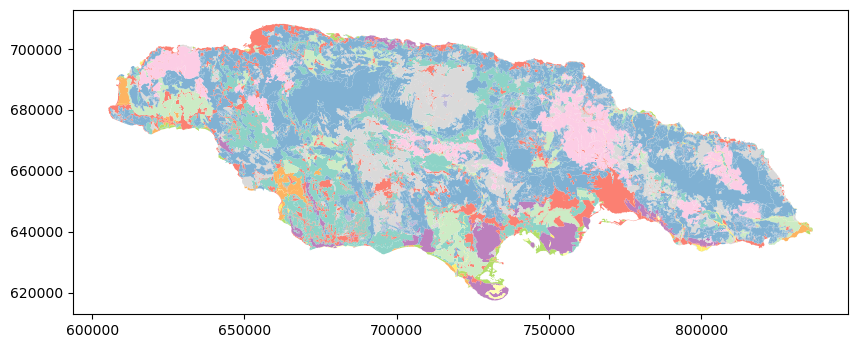

In [256]:
terrestrial_landcover.plot(column='Classify', 
             figsize=(10, 8), 
             #legend=True,
             cmap='Set3',  # You can change the colormap as needed
             legend_kwds={'bbox_to_anchor': (1, 1), 'title': 'Land Use'})

In [257]:
mangroves_FN_path = base_path / "Mangroves_FN/mangroves.shp" 
mangroves_FN = gpd.read_file(mangroves_FN_path)

<Axes: >

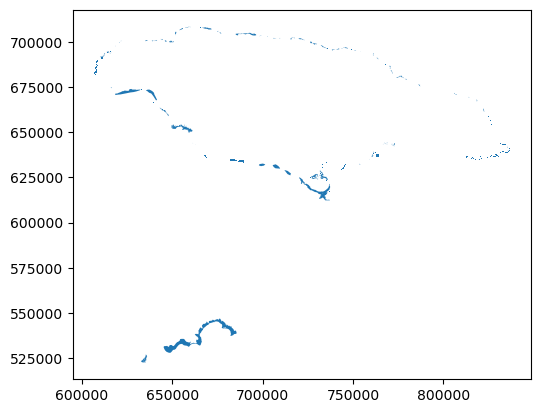

In [258]:
seagrass_path = base_path / "Seagrass/Seagrass.shp" 
seagrass = gpd.read_file(seagrass_path)
seagrass.plot()

<Axes: >

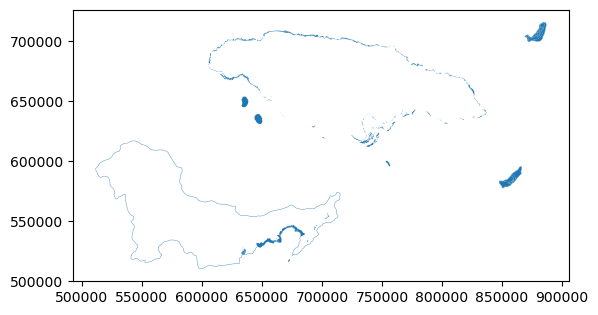

In [259]:
corals_path = base_path / "Corals/Coral Reefs.shp" 
corals = gpd.read_file(corals_path)
corals.plot()

/var/folders/x6/l70lvh3n02zd5hydyxdh1l0h0000gn/T/ipykernel_9027/1372187848.py:40: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right')  # Position the legend
/var/folders/x6/l70lvh3n02zd5hydyxdh1l0h0000gn/T/ipykernel_9027/1372187848.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')  # Position the legend


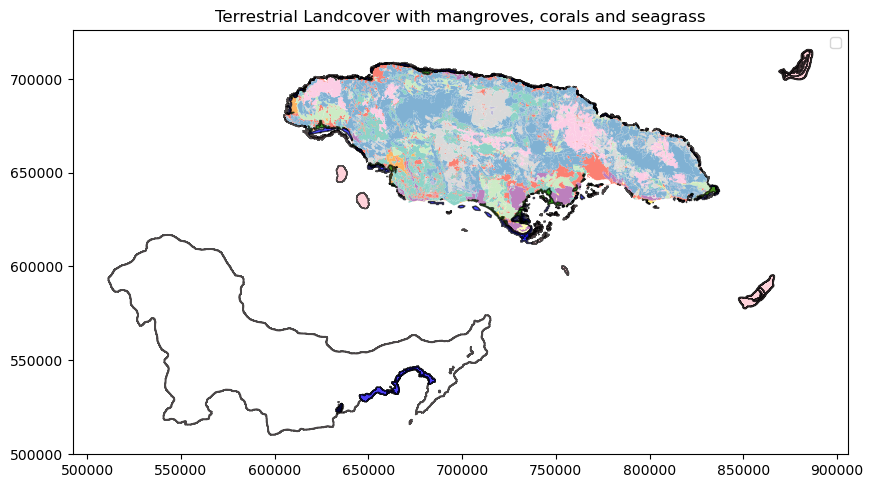

In [260]:
# Plot terrestrial landcover
fig, ax = plt.subplots(figsize=(10, 8))
terrestrial_landcover.plot(
    column='Classify',
    ax=ax,
    cmap='Set3',  # You can change the colormap as needed
    legend_kwds={'bbox_to_anchor': (1, 1), 'title': 'Land Use'},
)

# Overlay mangroves layer
mangroves_FN.plot(
    ax=ax,
    color='green',  # Specify color for mangroves
    edgecolor='black',  # Add borders to mangrove polygons
    alpha=0.7,  # Adjust transparency
    label='Mangroves',  # Add a label for the legend
)

# Overlay seagrass layer
corals.plot(
    ax=ax,
    color='pink',  # Specify color for mangroves
    edgecolor='black',  # Add borders to mangrove polygons
    alpha=0.7,  # Adjust transparency
    label='corals',  # Add a label for the legend
)

# Overlay corals layer
seagrass.plot(
    ax=ax,
    color='blue',  # Specify color for mangroves
    edgecolor='black',  # Add borders to mangrove polygons
    alpha=0.7,  # Adjust transparency
    label='seagrass',  # Add a label for the legend
)


# Customize plot
plt.title("Terrestrial Landcover with mangroves, corals and seagrass")
plt.legend(loc='upper right')  # Position the legend
plt.show()

In [261]:
# Check and align CRS
if seagrass.crs != jamaica_boundary.crs:
    seagrass = seagrass.to_crs(jamaica_boundary.crs)

In [262]:
# Create a buffer around the coastline
buffer_distance_10000m = 10000  # Example: 10,000 meters (10 km)
jamaica_buffered_10000m = jamaica_boundary.buffer(buffer_distance_10000m)

# If the boundary consists of multiple polygons, combine them into a single geometry
jamaica_buffered_10000m_unary = jamaica_buffered_10000m.unary_union

# Create a buffer around the coastline
buffer_distance_15000m = 15000  # Example: 15,000 meters (15 km)
jamaica_buffered_15000m = jamaica_boundary.buffer(buffer_distance_15000m)

# If the boundary consists of multiple polygons, combine them into a single geometry
jamaica_buffered_10000m_unary = jamaica_buffered_10000m.unary_union
jamaica_buffered_15000m_unary = jamaica_buffered_15000m.unary_union

/var/folders/x6/l70lvh3n02zd5hydyxdh1l0h0000gn/T/ipykernel_9027/3034147599.py:5: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/x6/l70lvh3n02zd5hydyxdh1l0h0000gn/T/ipykernel_9027/3034147599.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


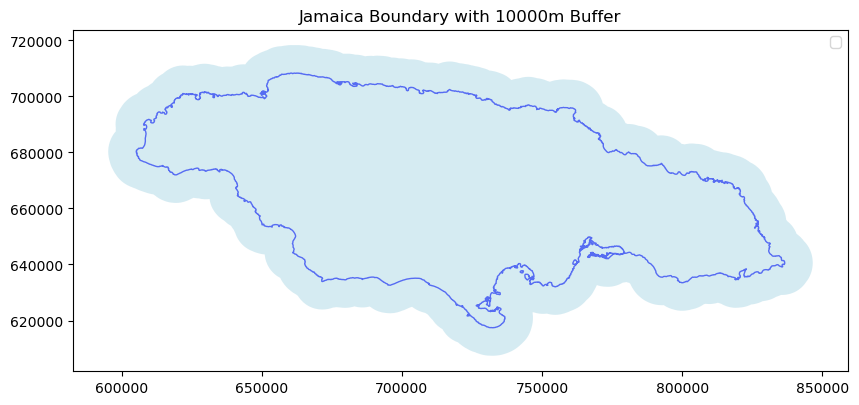

In [263]:
# Plot the original boundary and the buffered area
fig, ax = plt.subplots(figsize=(10, 10))
jamaica_boundary.plot(ax=ax, color='none', edgecolor='blue', label='Jamaica Boundary')
gpd.GeoSeries(jamaica_buffered_10000m_unary).plot(ax=ax, color='lightblue', alpha=0.5, label='Buffered Area')
plt.legend()
plt.title("Jamaica Boundary with 10000m Buffer")
plt.show()

/var/folders/x6/l70lvh3n02zd5hydyxdh1l0h0000gn/T/ipykernel_9027/3727197977.py:5: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/x6/l70lvh3n02zd5hydyxdh1l0h0000gn/T/ipykernel_9027/3727197977.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


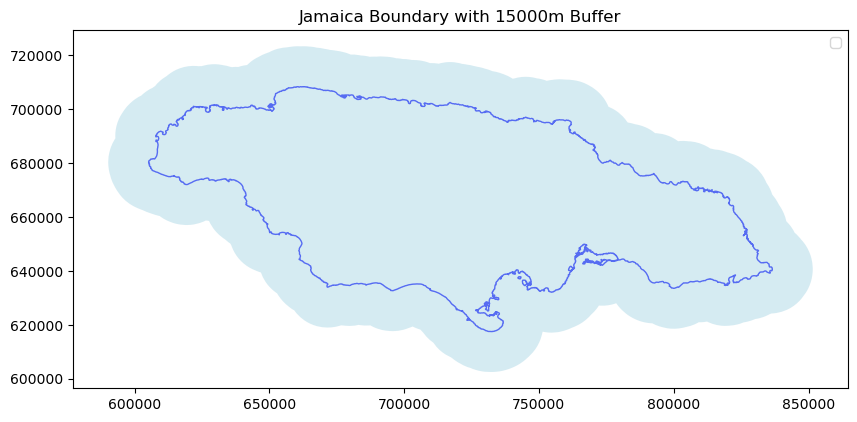

In [264]:
# Plot the original boundary and the buffered area
fig, ax = plt.subplots(figsize=(10, 10))
jamaica_boundary.plot(ax=ax, color='none', edgecolor='blue', label='Jamaica Boundary')
gpd.GeoSeries(jamaica_buffered_15000m_unary).plot(ax=ax, color='lightblue', alpha=0.5, label='Buffered Area')
plt.legend()
plt.title("Jamaica Boundary with 15000m Buffer")
plt.show()

In [265]:
# Clip seagrass layer to the buffered area
seagrass_clipped_10000m = gpd.clip(seagrass, jamaica_buffered_10000m_unary)
seagrass_clipped_15000m = gpd.clip(seagrass, jamaica_buffered_15000m_unary)

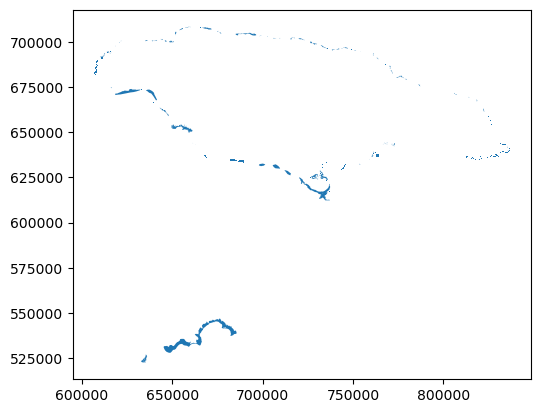

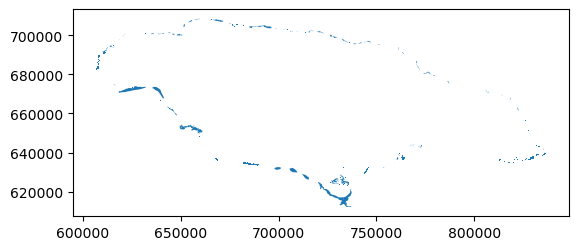

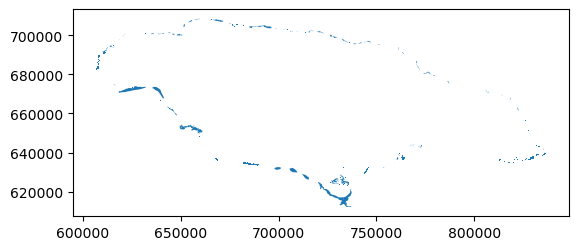

In [266]:
seagrass_10000m_output_path = base_path / "seagrass_clipped_10000m.shp"
seagrass_clipped_10000m.to_file(output_path)

seagrass.plot()
seagrass_clipped_15000m.plot()
seagrass_clipped_10000m.plot()

seagrass_15000m_output_path = base_path / "seagrass_clipped_15000.shp"
seagrass_clipped_15000m.to_file(output_path)


In [267]:
# Clip coral layer to the buffered area
corals_clipped_10000m = gpd.clip(corals, jamaica_buffered_10000m_unary)
corals_clipped_15000m = gpd.clip(corals, jamaica_buffered_15000m_unary)

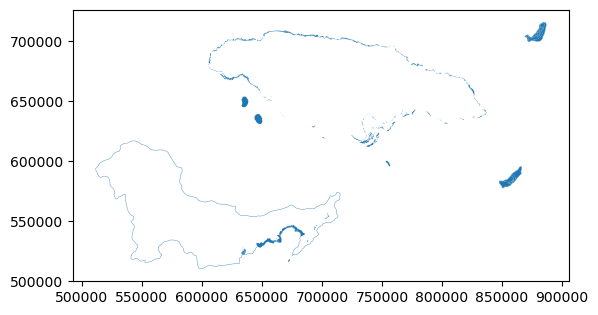

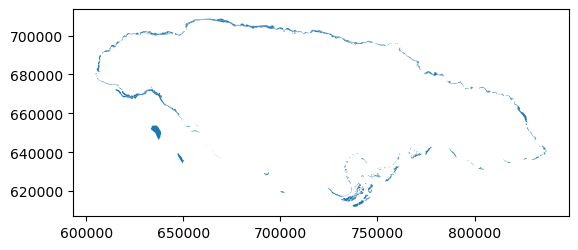

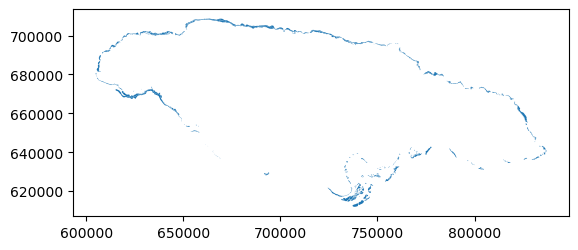

In [268]:
corals.plot()
corals_clipped_15000m.plot()
corals_clipped_10000m.plot()


corals_10000m_output_path = base_path / "corals_clipped_10000m.shp"
corals_15000m_output_path = base_path / "corals_clipped_15000m.shp"

corals_clipped_10000m.to_file(output_path)

In [269]:
output_path = base_path / "corals_clipped_1000m.shp"
corals_clipped_1000m.to_file(output_path)

In [270]:
forest_reserves = base_path / "protected_landcover/Forest_reserves.shp"
protected_areas = base_path / "protected_landcover/Protected_areas.shp"

In [271]:
forest_reserve_areas = gpd.read_file(forest_reserves)
forest_reserve_areas = forest_reserve_areas.to_crs(jamaica_metric_grid_crs)
protected_areas_file = gpd.read_file(protected_areas)
protected_areas_file = protected_areas_file.to_crs(jamaica_metric_grid_crs)

<Axes: >

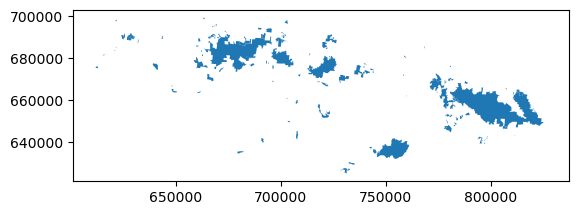

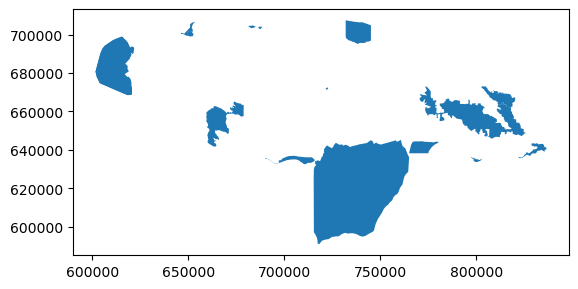

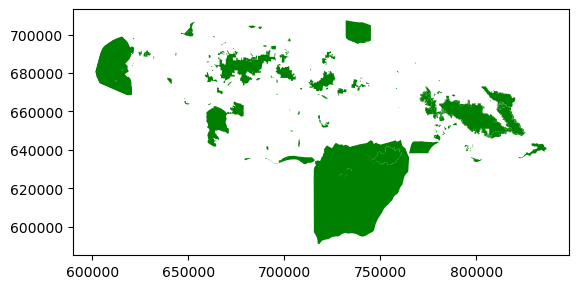

In [272]:
forest_reserve_areas.plot()
protected_areas_file.plot()
combined_protected_layers = gpd.overlay(forest_reserve_areas, protected_areas_file, how='union')
combined_protected_layers.plot(color='green')

/var/folders/x6/l70lvh3n02zd5hydyxdh1l0h0000gn/T/ipykernel_9027/2236959973.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/x6/l70lvh3n02zd5hydyxdh1l0h0000gn/T/ipykernel_9027/2236959973.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


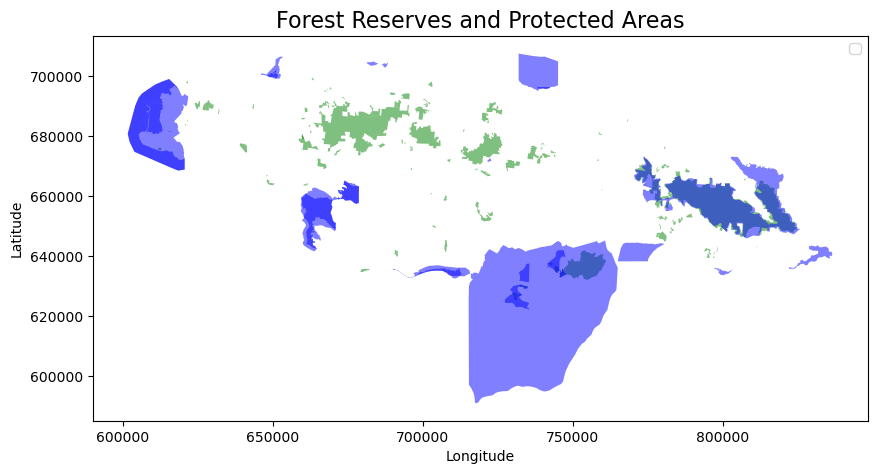

In [273]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the first shapefile (forest reserves) on the axis
forest_reserve_areas.plot(ax=ax, color='green', alpha=0.5, label='Forest Reserves')

# Plot the second shapefile (protected areas) on the same axis
protected_areas_file.plot(ax=ax, color='blue', alpha=0.5, label='Protected Areas')

# Add a legend
ax.legend()

# Optionally, add title and labels
ax.set_title('Forest Reserves and Protected Areas', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()


In [274]:
protected_layers_landuse = gpd.overlay(combined_protected_layers, terrestrial_landcover, how='intersection')

<Axes: >

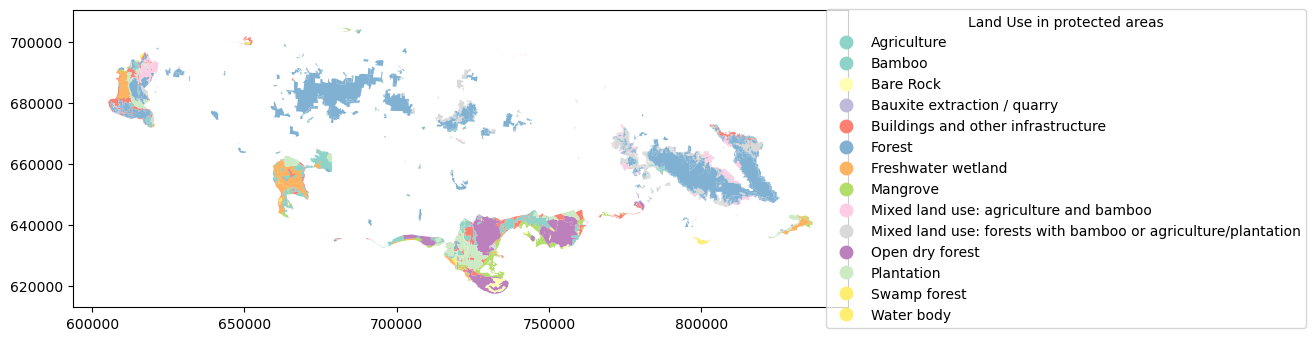

In [275]:
protected_layers_landuse.plot(column='Classify', 
             figsize=(10, 8), 
             legend=True,
             cmap='Set3',  # You can change the colormap as needed
             legend_kwds={'bbox_to_anchor': (1.60, 1.025), 'title': 'Land Use in protected areas'})

In [276]:
# proposed_protected_areas = base_path / "protected_areas_PROPOSED_PROTECTED_AREA.gpkg"

proposed_protected_areas = gpd.read_file(base_path / "protected_areas_PROPOSED_PROTECTED_AREA.gpkg")

proposed_protected_areas = proposed_protected_areas.to_crs(jamaica_metric_grid_crs)


<Axes: >

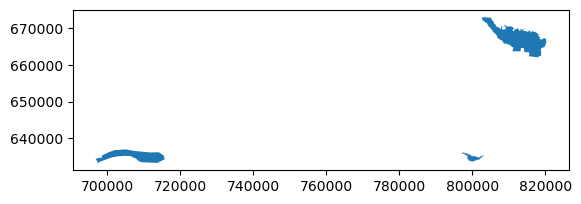

In [277]:
proposed_protected_areas.plot()

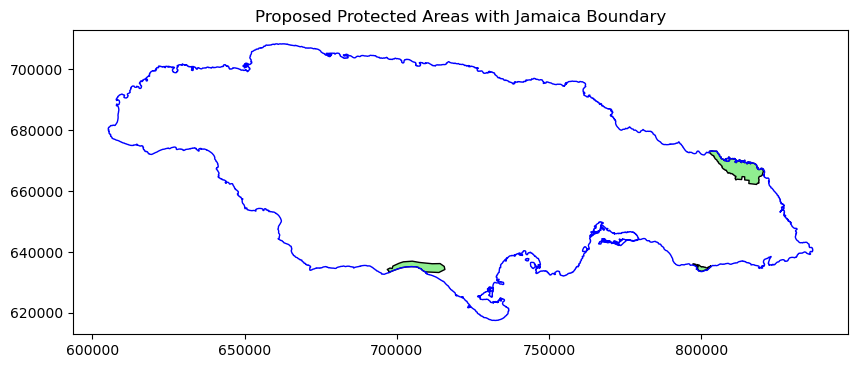

In [278]:
# Create the base plot for proposed protected areas
ax = proposed_protected_areas.plot(color="lightgreen", edgecolor="black", figsize=(10, 10))
# Overlay the Jamaica boundary
jamaica_boundary.plot(ax=ax, color="none", edgecolor="blue", linewidth=1)
# Add titles and legends
plt.title("Proposed Protected Areas with Jamaica Boundary")
plt.show()

In [279]:
# intersect proposed protected areas with land use

proposed_protected_layers_landuse = gpd.overlay(proposed_protected_areas, terrestrial_landcover, how='intersection')

<Axes: >

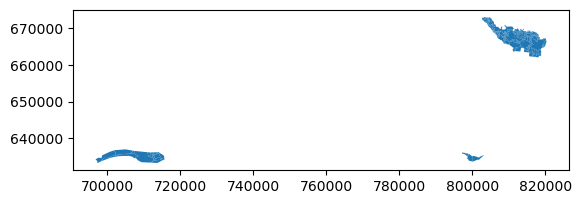

In [280]:
proposed_protected_layers_landuse.plot()

In [281]:
display(proposed_protected_layers_landuse.head())

,OBJECTID_1,ENTITY,LAYER,NAME,PARISH,DECL_DATE,DECL_ACT,Shape_Leng_1,Shape_Area_1,OBJECTID_2,Classify,Hectares,Shape_Leng_2,LU_CODE,Shape_Le_1,Shape_Area_2,Area new,area_m2,color,geometry
0,17.0,Polyline,PROPOSED_PROTECTED_AREA,Alligator Pond Protected Area (Proposed),Clarendon and Manchester,None,None,41935.483333,3.790527e+07,113,Agriculture,12.627439,1613.030115,FC,1613.030115,1.262744e+05,1.262744e+05,1.262744e+05,#8B4513,"POLYGON ((712777.170 633930.221, 712805.788 63..."
1,17.0,Polyline,PROPOSED_PROTECTED_AREA,Alligator Pond Protected Area (Proposed),Clarendon and Manchester,None,None,41935.483333,3.790527e+07,116,Agriculture,8.091785,1215.482870,FC,1215.482870,8.091785e+04,8.091785e+04,8.091785e+04,#8B4513,"POLYGON ((712615.038 635259.485, 712594.260 63..."
2,17.0,Polyline,PROPOSED_PROTECTED_AREA,Alligator Pond Protected Area (Proposed),Clarendon and Manchester,None,None,41935.483333,3.790527e+07,227,Agriculture,4968.745874,155264.946814,FC,155264.946814,4.968746e+07,4.968746e+07,4.968746e+07,#8B4513,"POLYGON ((702719.350 636730.232, 702666.025 63..."
3,17.0,Polyline,PROPOSED_PROTECTED_AREA,Alligator Pond Protected Area (Proposed),Clarendon and Manchester,None,None,41935.483333,3.790527e+07,1708,Freshwater wetland,88.332188,6582.043436,HW,6582.043436,8.833219e+05,8.833219e+05,8.833219e+05,#4169E1,"POLYGON ((701004.668 634599.929, 700732.520 63..."
4,17.0,Polyline,PROPOSED_PROTECTED_AREA,Alligator Pond Protected Area (Proposed),Clarendon and Manchester,None,None,41935.483333,3.790527e+07,1709,Freshwater wetland,21.755307,2153.908708,HW,2153.908708,2.175531e+05,2.175531e+05,2.175531e+05,#4169E1,"POLYGON ((703246.890 635034.017, 703213.777 63..."


In [282]:
slope_dem = base_path / "dem_30m/DEM_30m.tif"
with rasterio.open(slope_dem) as dem:
    print("DEM CRS:", dem.crs)

DEM CRS: EPSG:4326


In [283]:
output_dem_path = base_path / "reprojected_DEM_EPSG3448.tif"
with rasterio.open(slope_dem) as src:
    # Calculate the transform and metadata for the new CRS
    transform, width, height = calculate_default_transform(
        src.crs, "EPSG:3448", src.width, src.height, *src.bounds)
    # Update metadata for the new DEM
    new_meta = src.meta.copy()
    new_meta.update({
        "crs": "EPSG:3448",
        "transform": transform,
        "width": width,
        "height": height
    })
    
    # Create the reprojected DEM
    with rasterio.open(output_dem_path, "w", **new_meta) as dest:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dest, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs="EPSG:3448",
                resampling=Resampling.nearest
            )

print(f"Reprojected DEM saved to: {output_dem_path}")

Reprojected DEM saved to: /Users/robynhaggis/Documents/Geospatial_analysis/Inputs/reprojected_DEM_EPSG3448.tif


DEM CRS: EPSG:3448


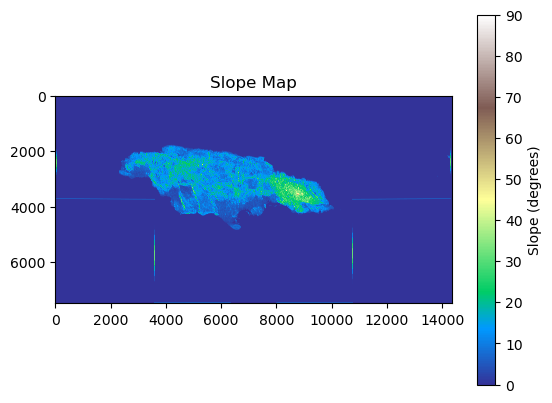

In [284]:
reprojected_slope_dem = base_path / "reprojected_DEM_EPSG3448.tif"


with rasterio.open(reprojected_slope_dem) as dem:
    print("DEM CRS:", dem.crs)
    # Read the DEM data
    dem_data = dem.read(1)  # Read the first band (elevation values)
    dem_affine = dem.transform  # Affine transform for georeferencing

# Calculate the gradients in the x and y directions
gradient_x, gradient_y = np.gradient(dem_data, dem_affine[0], dem_affine[4])  # Pixel sizes in x and y directions

# Calculate slope (in radians)
slope_radians = np.sqrt(gradient_x**2 + gradient_y**2)

# Convert slope from radians to degrees
slope_degrees = np.arctan(slope_radians) * (180 / np.pi)

# Plot the slope map
plt.imshow(slope_degrees, cmap='terrain', vmin=0, vmax=90)
plt.colorbar(label="Slope (degrees)")
plt.title("Slope Map")
plt.show()
    

In [285]:
terrestrial_landcover_raster = np.zeros_like(dem_data, dtype=np.uint8)  # Initialize with zeros (no land use)
# Rasterize the land use polygons into the raster
for _, row in terrestrial_landcover.iterrows():
    geom = row['geometry']
    # Use rasterio.features.rasterize to convert polygons to raster
    mask = geometry_mask([geom], transform=dem_affine, invert=True, out_shape=dem_data.shape)
    terrestrial_landcover_raster[mask] = 1  # Mark the land use area with 1 (you can assign categories as needed)

# Step 3: Mask the slope raster using the land use raster
slope_masked = np.where(terrestrial_landcover_raster == 1, slope_degrees, np.nan)  # Masking the slope data based on land use

# Step 4: Visualize the masked slope map
plt.imshow(slope_masked, cmap='terrain', vmin=0, vmax=90)
plt.colorbar(label="Slope (degrees)")
plt.title("Slope Map Intersected with Land Use Areas")
plt.show()


KeyboardInterrupt: 

In [ ]:
# Step 1: Mask the slope raster to only include slopes between 20 and 36 degrees
slope_filtered = np.where((slope_degrees >= 20) & (slope_degrees <= 36), slope_degrees, np.nan)

# Step 2: Rasterize the land use to match the DEM and slope
terrestrial_landcover_raster = np.zeros_like(dem_data, dtype=np.uint8)  # Initialize with zeros (no land use)

# Rasterize land use polygons into the raster
for _, row in terrestrial_landcover.iterrows():
    geom = row['geometry']
    # Use rasterio.features.rasterize to convert polygons to raster
    mask = geometry_mask([geom], transform=dem_affine, invert=True, out_shape=dem_data.shape)
    terrestrial_landcover_raster[mask] = 1  # Mark land use areas

# Step 3: Mask the slope data by the land use raster
slope_in_terrestrial_landcover = np.where(terrestrial_landcover_raster == 1, slope_filtered, np.nan)

# Step 4: Plot the filtered slope map (only land use areas with slopes between 20° and 36°)
plt.imshow(slope_in_terrestrial_landcover, cmap='terrain', vmin=0, vmax=36)
plt.colorbar(label="Slope (degrees)")
plt.title("Filtered Slope Map (20° to 36°) for Land Use Areas")
plt.show()

# Optionally: If you want to analyze the land use areas with slopes within the desired range:
# Create a mask of the land use areas with slope in the range
filtered_terrestrial_landcover = terrestrial_landcover[terrestrial_landcover_raster == 1]


In [ ]:
# Define the path to your nsdmb geodatabase
nsdmb_path = base_path / "nsdmb/GWP_Jamaica_NSP_Master_Geodatabase_v01.gdb"

In [ ]:
# List all layers in the geodatabase
layers = fiona.listlayers(nsdmb_path)
print("Available layers in the geodatabase:")
for layer in layers:
    print(layer)

In [ ]:
# Choose a layer to load (replace 'your_layer_name' with the actual layer name)
layer_name = "bauxite_reserves"

# Read the layer into a GeoDataFrame
bauxite_reserves = gpd.read_file(nsdmb_path, layer=layer_name)

# Inspect the first few rows
print(gdf.head())

bauxite_reseves = bauxite_reserves.to_crs(jamaica_metric_grid_crs)
print(bauxite_reserves.crs)

In [ ]:
# Plot bauxite reserves
#gdf.plot(color="grey", edgecolor="black", figsize=(10, 10))
#plt.title("Bauxite Reserves")
#plt.show()


# Create a base plot for the Jamaica boundary
fig, ax = plt.subplots(figsize=(10, 10))
jamaica_boundary.plot(ax=ax, color="none", edgecolor="black", linewidth=1, label="Jamaica Boundary")

# Overlay the bauxite reserves
gdf.plot(ax=ax, color="grey", edgecolor="black", alpha=0.7, label="Bauxite Reserves")

# Add a title and legend
plt.title("Bauxite Reserves Over Jamaica Boundary")
plt.legend()
plt.show()


In [ ]:
# Perform intersection of bauxite reserves and land use
landcover_bauxite = gpd.overlay(bauxite_reserves, terrestrial_landcover, how="intersection")

# Inspect the result
print(landcover_bauxite.head())

In [ ]:
help(gpd)

In [ ]:
landcover_bauxite.plot()
display(intersection.head())